#Table of Contents
* [Initialization](#Initialization)
	* [Constants](#Constants)
		* [Dataset](#Dataset)
		* [MyMediaLite](#MyMediaLite)
		* [Experiments](#Experiments)
		* [Viz](#Viz)
	* [Prepare data](#Prepare-data)
	* [Prepare models](#Prepare-models)
	* [Set evaluation parameters](#Set-evaluation-parameters)
* [Run experiments](#Run-experiments)
* [Visualize results](#Visualize-results)
	* [Predictions from single negative feedback](#Predictions-from-single-negative-feedback)
	* [Predictions for "known" user](#Predictions-for-"known"-user)


In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.3)
sns.set_style('white')
mpl.rcParams['text.usetex'] = True #Type1 Fonts

from polara.recommender.data import RecommenderData, RecommenderDataPositive
from polara.recommender.models import SVDModel, CoffeeModel, NonPersonalized
from polara.evaluation import evaluation_engine as ee
from polara.tools.mymedialite.mmlwrapper import MyMediaLiteWrapper
from polara.tools.movielens import get_movielens_data
from polara.evaluation.plotting import show_hit_rates, show_precision_recall, show_ranking

# Initialization

## Constants

### Dataset

In [2]:
DATA_NAME = 'ml-1m'
DATA_FILE = '{}.zip'.format(DATA_NAME)#path to Movielens-1M zip-file
                                      #set it to None to automatically download data from Grouplens
SESS_SIZE = 20

### MyMediaLite

In [3]:
#set path to MyMediaLite binaries
if sys.platform == 'win32':
    LIB_PATH = 'MyMediaLite-3.11/lib/mymedialite' 
else:
    LIB_PATH = 'MyMediaLite-3.11/bin'

MML_DATA = 'MyMediaLiteData' #folder to store MyMediLite data (models, data mappings, etc.)

### Experiments

In [4]:
RESULTS_DIR = 'results'
EXPERIMENT_NAME = 'ACM'

### Viz

In [5]:
ERR_ALPHA = 0.05

## Prepare data

In [6]:
ml_data = get_movielens_data(local_file=DATA_FILE, get_genres=False)

In [7]:
def filter_by_length(data, user_id='userid', session_length=SESS_SIZE):
    """Filters users with insufficient number of items"""
    sz = data.groupby(user_id, sort=False).size()
    short_sessions = sz < session_length
    if (short_sessions < session_length).any():
        valid_users = sz.index[(sz > session_length)]
        new_data =  data[data.userid.isin(valid_users)]
        print 'Sessions are filtered by length'
    else:
        new_data = data
    return new_data

In [8]:
ml_data = filter_by_length(ml_data)
data_model = RecommenderData(ml_data, 'userid', 'movieid', 'rating')
data_model.name = DATA_NAME

Sessions are filtered by length


## Prepare models

In [9]:
bpr = MyMediaLiteWrapper(LIB_PATH, MML_DATA, 'BPRMF', data_model)
wrmf = MyMediaLiteWrapper(LIB_PATH, MML_DATA, 'WRMF', data_model)
svd = SVDModel(data_model)
popular =  NonPersonalized('mostpopular', data_model)
random = NonPersonalized('random', data_model)
coffee = CoffeeModel(data_model)

In [10]:
models = [bpr, wrmf, svd, coffee, popular, random]
model_names = [model.method for model in models]
metrics = ['ranking', 'relevance']
model_names

['BPRMF', 'WRMF', 'SVD', 'CoFFee', 'mostpopular', 'random']

In [11]:
for model in models[:4]:
    try:
        rank = model.rank
    except AttributeError:
        rank = model.mlrank
        
    print '{} rank: {}'.format(model.method, rank)

BPRMF rank: 10
WRMF rank: 10
SVD rank: 10
CoFFee rank: (13, 10, 2)


## Set evaluation parameters

In [12]:
topk_list = [1, 2, 3, 5, 10, 15, 20, 30, 50, 70, 100]
test_samples = [-1, 0]
folds = [1, 2, 3, 4, 5]

In [13]:
data_model.holdout_size = 10
data_model.random_holdout = True

# Run experiments

In [14]:
result = {}
topk_result = {}
for test_sample in test_samples:
    data_model.test_sample = test_sample
    print '\n\n========= Test sample: {} =========\n'.format(test_sample)
    for fold in folds:
        print '\n============ Fold: {} ============='.format(fold)
        data_model.test_fold = fold
        topk_result[fold] = ee.topk_test(models, topk_list=topk_list, metrics=metrics)
    result[test_sample] = ee.consolidate_folds(topk_result, folds, metrics)

ee.save_scores(result, DATA_NAME, EXPERIMENT_NAME, save_folder=RESULTS_DIR)



========= Test sample: -1 =========


============ Fold: 1 =============
Preparing data
Data has been changed. Rebuiding the models.
SVD model training time: 0.0840111816751s
CoFFee model training time: 3.2236491033s
100 70 50 30 20 15 10 5 3 2 1 
============ Fold: 2 =============
Preparing data
Data has been changed. Rebuiding the models.
SVD model training time: 0.0755736068785s
CoFFee model training time: 2.28484122686s
100 70 50 30 20 15 10 5 3 2 1 
============ Fold: 3 =============
Preparing data
Data has been changed. Rebuiding the models.
SVD model training time: 0.0769526363521s
CoFFee model training time: 2.08079125665s
100 70 50 30 20 15 10 5 3 2 1 
============ Fold: 4 =============
Preparing data
Data has been changed. Rebuiding the models.
SVD model training time: 0.0796150377026s
CoFFee model training time: 1.80771016651s
100 70 50 30 20 15 10 5 3 2 1 
============ Fold: 5 =============
Preparing data
Data has been changed. Rebuiding the models.
SVD model training tim

# Visualize results

In [15]:
file_path_tmpl = "{}/{}_{}_({{}})_{{}}.csv".format(RESULTS_DIR, DATA_NAME, EXPERIMENT_NAME)

In [16]:
def get_results(metric, test_sample):
    filepath = file_path_tmpl.format(test_sample, metric)
    data = pd.read_csv(filepath, header=[0, 1], index_col=[0, 1])
    res, err = ee.average_results({metric:data})
    return res, err

In [17]:
def format_plots(ax):
    handles = {}
    labels = {}
    colors = {}
    for i, axi in enumerate(ax):
        axi.set_ylim(ymin=0)

        handles[i], labels[i] = axi.get_legend_handles_labels()
        handle = handles[i]
        if i == 0:
            for j in range(len(handle)):
                colors[j] = handle[j].get_color()
        else:
            for j in range(len(handle)):
                handle[j].set_color(colors[j])
        labels[i], handles[i] = zip(*sorted(zip(labels[i], handles[i]), key=lambda t: t[0]))

    for i, lable in enumerate(labels):
        labels[i] = [name if name!='mostpopular' else 'most popular' for name in labels[i]]

def format_labels(ax):
    ax[2].set_xlabel('top-$n$')
    ax[3].set_xlabel('top-$n$')
    ax[2].set_ylabel('nDCG@$n$')
    ax[3].set_ylabel('nDCL@$n$')
    ax[1].set_xlabel('Recall@$n$')
    ax[1].set_ylabel('Precision@$n$')

## Predictions from single negative feedback

In [18]:
test_sample = -1

In [19]:
res, err = get_results('relevance', test_sample)
resr, errr = get_results('ranking', test_sample)

C:\Users\evfro\Anaconda\envs\scicomp2x\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


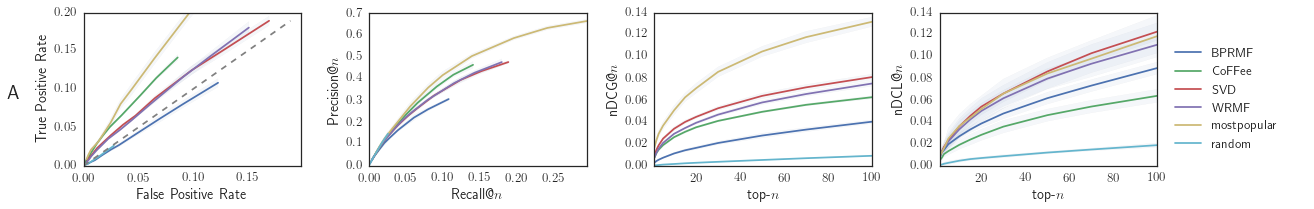

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3))

show_hit_rates(res, errors=err, err_alpha=ERR_ALPHA, ax=ax[0], ROC_middle=True);
show_precision_recall(res, errors=err, err_alpha=ERR_ALPHA, ax=ax[1])
show_ranking(resr, errors=errr, err_alpha=ERR_ALPHA, ax=(ax[2], ax[3]))

format_plots(ax)
format_labels(ax)

txt = ax[0].text(-0.07, 0.087, 'A', fontsize=20)
lgnd = fig.legend(*ax[3].get_legend_handles_labels(), loc='upper left', bbox_to_anchor=(1.01,0.8))
plt.tight_layout()
# plt.savefig("ml1m.pdf", bbox_extra_artists=(lgnd, txt), bbox_inches='tight')

## Predictions for "known" user

In [21]:
test_sample = 0

In [22]:
res, err = get_results('relevance', test_sample)
resr, errr = get_results('ranking', test_sample)

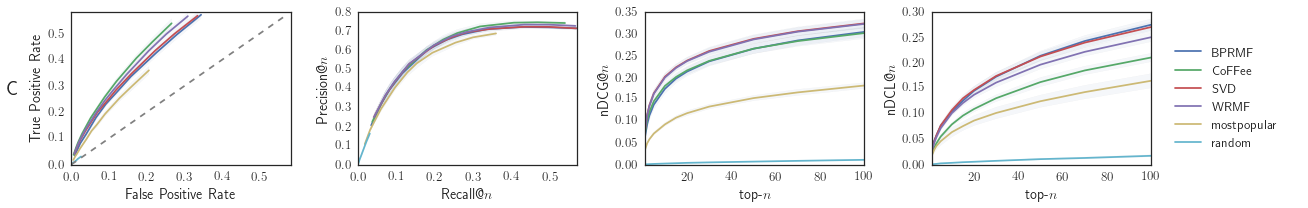

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3))

show_hit_rates(res, errors=err, err_alpha=ERR_ALPHA, ax=ax[0], ROC_middle=True);
show_precision_recall(res, errors=err, err_alpha=ERR_ALPHA, ax=ax[1])
show_ranking(resr, errors=errr, err_alpha=ERR_ALPHA, ax=(ax[2], ax[3]))

format_plots(ax)
format_labels(ax)

txt = ax[0].text(-0.17, 0.27, 'C', fontsize=20)
lgnd = fig.legend(*ax[3].get_legend_handles_labels(), loc='upper left', bbox_to_anchor=(1.01,0.8))
plt.tight_layout()
# plt.savefig("ml1m_all.pdf", bbox_extra_artists=(lgnd, txt), bbox_inches='tight')